<a href="https://colab.research.google.com/github/jsong55/Machine_Learning/blob/master/AF_classification_using_ConvNet2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import random
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential, layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
import datetime
import tensorflow_hub as hub

In [2]:
!wget https://raw.githubusercontent.com/jsong55/Machine_Learning/master/TF_functions.py
from TF_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, view_random_image

--2022-10-23 22:54:08--  https://raw.githubusercontent.com/jsong55/Machine_Learning/master/TF_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10747 (10K) [text/plain]
Saving to: ‘TF_functions.py’

TF_functions.py     100%[===================>]  10.50K  --.-KB/s    in 0s      

2022-10-23 22:54:08 (109 MB/s) - ‘TF_functions.py’ saved [10747/10747]



## Acquire the data

image shape: (150, 150, 3)


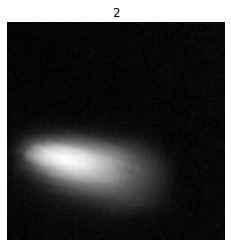

In [5]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/python_torturial/NW_image_quality_50tests_rgb.zip","r")
zip_ref.extractall()
zip_ref.close()

# Setup the train and test directories
train_dir = "NW_image_quality_50tests_rgb/train/"
test_dir = "NW_image_quality_50tests_rgb/test/"
# visualize
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

img = view_random_image(target_dir=train_dir,
              target_class=random.choice(class_names))

In [6]:
IMAGE_SIZE = (150,150)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                        image_size=IMAGE_SIZE,
                                        label_mode="categorical",
                                        batch_size=32,
                                        shuffle=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                  image_size=IMAGE_SIZE,
                                  label_mode="categorical",
                                  batch_size=32)

Found 2988 files belonging to 5 classes.
Found 1200 files belonging to 5 classes.


## Get the Base model: ConvNet

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# Check the layers in our base model
#for layer_number, layer in enumerate(base_model.layers):
#  print(layer_number, layer.name)

# The model contains a noramlization and rescaling layer

# 2. Free the base model (the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(150,150,3),name="input_layer")

# 4. If using a model like ResNet50V2, you will need to noramlize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(5,activation="softmax",name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
        optimizer = Adam(),
        metrics=["accuracy"])

# 10. Fit the model and save the history
history_0 = model_0.fit(train_data,
                  epochs=50,
                  steps_per_epoch=len(train_data),
                  validation_data=test_data,
                  validation_steps=int(0.1*len(test_data)),
                  callbacks=[create_tensorboard_callback(dir_name="ConvNet",
                                      experiment_name="ConvNet_test1")])

shape after passing inputs through base model: (None, 4, 4, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: ConvNet/ConvNet_test1/20221023-230905
Epoch 1/50
94/94 [==============================] - 11s 53ms/step - loss: 1.3334 - accuracy: 0.4103 - val_loss: 1.1443 - val_accuracy: 0.5000
Epoch 2/50
94/94 [==============================] - 4s 37ms/step - loss: 1.1501 - accuracy: 0.4749 - val_loss: 1.0228 - val_accuracy: 0.4688
Epoch 3/50
94/94 [==============================] - 4s 38ms/step - loss: 1.0756 - accuracy: 0.5191 - val_loss: 1.0322 - val_accuracy: 0.5208
Epoch 4/50
94/94 [==============================] - 4s 41ms/step - loss: 1.0421 - accuracy: 0.5298 - val_loss: 1.0717 - val_accuracy: 0.4896
Epoch 5/50
94/94 [==============================] - 4s 44ms/step - loss: 1.0187 - accuracy: 0.5502 - val_loss: 1.0735 - val_accuracy: 0.3958
Epoch 6/50
94/94 [==============================] - 4s 39ms/step - loss: 0.9897 - accuracy: 0.5616 - val_los

In [8]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_________________________________________________________________


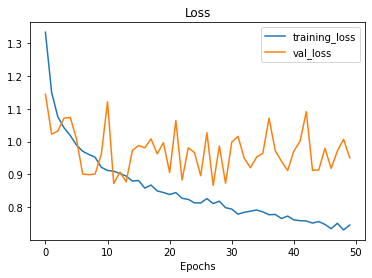

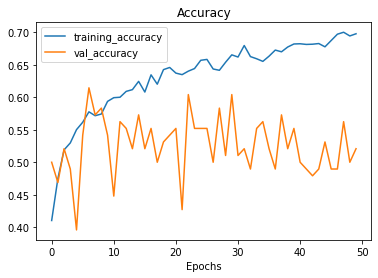

In [13]:
plot_loss_curves(history_0)

In [14]:
results_0 = model_0.evaluate(test_data)
results_0

38/38 [==============================] - 2s 46ms/step - loss: 0.9563 - accuracy: 0.5433


[0.956339418888092, 0.5433333516120911]